### Import

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import shapefile
import re
import pickle
import time
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from tqdm import tqdm
from collections import Counter
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist

### Load Graph

In [2]:
X = pickle.load(open("../data/graphs/nyc.p","rb"))
O = X['O']
N = X['N']
edges = X['edges']
nodes = X['nodes']
nodenames = X['nodenames']
edgedatabase = X['edgedatabase']
streets = X['streets']
G = X['G']
Nlist = X['Nlist'].tolist()
pickle.dump(X,open('../data/graphs/nyc.p',"wb"))

### Get Lengths

In [3]:
def computeLength(path,G):
    
    #Compute Length
    lengths = []
    for i in range(len(path)-1):
        orig = path[i]
        dest = path[i+1]
        weight = G[orig][dest]['weight']
        lengths.append(weight)

    #Return
    return lengths

### Compute a sampling of distance for discretization purposes

In [4]:
lengths = []
unconnected = []
for i in tqdm(range(5000)):
    source = np.random.randint(len(G))
    target = np.random.randint(len(G))
    try:
        path = nx.shortest_path(G, target=target,source=source)
        lengths = lengths + computeLength(path,G)
    except:
        unconnected.append((source,target))

100%|██████████| 5000/5000 [11:49<00:00,  7.05it/s]


### Examine Unconnected

In [5]:
isolatednodes = []
for target,source in unconnected:
    
    #Determine if target or source is the issue
    try:
        path = nx.shortest_path(G, target=0,source=source)
    except:
        badnode = source
    try:
        path = nx.shortest_path(G, target=target,source=0)
    except:
        badnode = target
        
    #Determine whether the bad node is connected at all
    counter = 0
    for i in range(100):
        randomnode = np.random.randint(len(G))
        try:
            path = nx.shortest_path(G, target=randomnode,source=badnode)
        except:
            counter = counter + 1
    if (counter == 100):
        isolatednodes.append(badnode)
isolatednodes = np.unique(isolatednodes)

### Get Unconnected nodes

In [6]:
keys = list(G.nodes.keys())
for nodeindex in isolatednodes:
    print(nodeindex,nodes[nodeindex])

19885 {'20455-manhattan': 's', '20454-manhattan': 'e'}
49111 {'52654-manhattan': 's'}
60020 {'1427-thebronx': 's', '19215-thebronx': 's', '37229-thebronx': 'e', '62021-thebronx': 'e'}
60022 {'1429-thebronx': 's', '1428-thebronx': 'e'}
60026 {'1433-thebronx': 's', '15148-thebronx': 's', '46016-thebronx': 's', '50866-thebronx': 'e'}
60030 {'1437-thebronx': 's', '1436-thebronx': 'e'}
60270 {'1678-thebronx': 's', '1677-thebronx': 'e'}
60274 {'1682-thebronx': 's', '30524-thebronx': 's', '10061-thebronx': 'e', '50248-thebronx': 'e'}
60393 {'1801-thebronx': 's', '1800-thebronx': 'e'}
60444 {'1852-thebronx': 's', '27941-thebronx': 'e'}
63916 {'5357-thebronx': 's', '5356-thebronx': 'e'}
63940 {'5382-thebronx': 's', '10379-thebronx': 's', '20595-thebronx': 'e', '37983-thebronx': 'e'}
71362 {'12965-thebronx': 's', '12964-thebronx': 'e'}
71397 {'13003-thebronx': 's', '8676-thebronx': 'e'}
71399 {'13006-thebronx': 's', '33567-thebronx': 's', '64829-thebronx': 'e', '70280-thebronx': 'e'}
71433 {'130

### Discretize

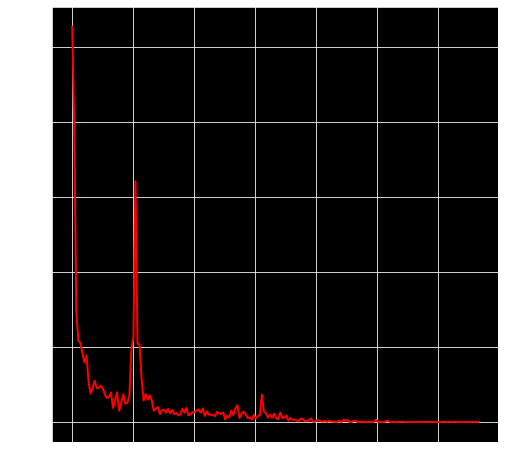

In [7]:
lengths = np.array(lengths)
minval = np.floor(np.min(lengths))
maxval = np.ceil(np.max(lengths))
nBins = 1000
hc,hb = np.histogram(lengths,bins=nBins)
hc = hc[:200]
hb = hb[:200]
plt.figure(figsize=(8,8))
plt.style.use('dark_background')
plt.plot(hb,hc,'r',linewidth=2);
plt.grid()

### Pair Exists in data

In [8]:
def pairExists(source,target,P):

    #Determine if pair exists
    exists = True
    if (source not in P and target not in P):
        exists = False
    if (source in P and target not in P):
        if target not in P[source]:
            exists = False
    if (source not in P and target in P):
        if source not in P[target]:
            exists = False    
    if (source in P and target not in P):
        if target in P[source]:
            exists = True
    if (target in P and source not in P):
        if source in P[target]:
            exists = True
    
    #Return
    return exists

### Queue Based distance computation

In [108]:
#Init
D = {}
P = {}
totcount = 0
runcount = 0
totcounts = []
runcounts = []
nNodes = len(nodes)
nodes = list(range(len(G)))
startNode = 0
durations = []

#Loop through cude
for i in tqdm(range(200)):
    start = time.time()
    for j in range(i+1,200):
    
        #Get Source and Target
        source = nodes[i]
        target = nodes[nNodes-j-1]
        pair = {source,target}
        totcount = totcount + 1

        #Check for exsistence of pair
        exists = pairExists(source,target,P)

        #If pair does not exsist
        if (exists == False):

            #Initial Path
            runcount = runcount + 1
            paths = nx.shortest_path(G, target=target,source=source)
            pathlengths = computeLength(paths,G)

            #Create Queue
            pairs = []
            for p1 in range(len(paths)):
                for p2 in range(p1,len(paths)):
                    start_index = paths[p1]
                    end_index = paths[p2]
                    if (start_index != end_index):
                        exists = pairExists(start_index,end_index,P)
                        if (exists == False):
                            pairs.append({start_index:p1,end_index:p2})

            #Empty Queue
            while (len(pairs) > 0):
                pairdic = pairs.pop(0)
                pairlist = list(pairdic.keys())
                start_index = pairlist[0]
                end_index = pairlist[1]
                curpair = {start_index,end_index}
                p1 = pairdic[start_index]
                p2 = pairdic[end_index]
                exists = pairExists(start_index,end_index,P)
                
                #If node pair not already exists
                if (exists == False):
                    
                    #Compite Lengths
                    sub_length = np.sum(pathlengths[p1:p2])
                    #length_index = np.argmin((sub_length - hb)**2)

                    #If Start Index or End Index are both even in P
                    if (start_index in P and end_index in P):
                        curdict = P[start_index]
                        curdict[end_index] = (sub_length)
                        P[start_index] = curdict
                        curdict = P[end_index]
                        curdict[start_index] = (sub_length)
                        P[end_index] = curdict

                    #If Top Level Node exists, but bottom level node does noet
                    if (start_index in P and end_index not in P):
                        curdict = P[start_index]
                        curdict[end_index] = (sub_length)
                        P[start_index] = curdict
                    if (start_index not in P and end_index in P):
                        curdict = P[end_index]
                        curdict[start_index] = (sub_length)
                        P[end_index] = curdict
                    
                    #If Top Level node doesn't even exist
                    if (start_index not in P and end_index not in P):
                        P[start_index] = {end_index:(sub_length)}  

        #Keep track of counts                
        totcounts.append(totcount)
        runcounts.append(runcount)

    #Stop the clock
    end = time.time()
    durations.append(end-start)

#Stop clock and calculate time
end1 = time.time()
print('Elapsed Time: ',end1 - start1)

100%|██████████| 200/200 [02:56<00:00,  1.13it/s]

Elapsed Time:  647.0755631923676


### Algorithm Spedding Up

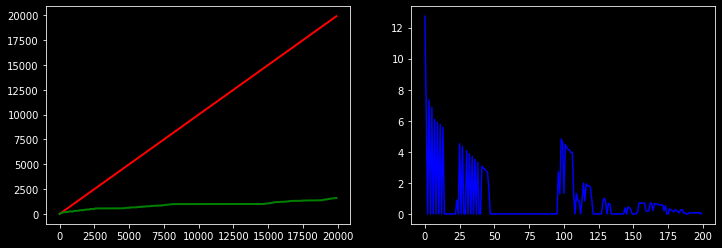

In [110]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1);
plt.plot(totcounts,'r',linewidth=2)
plt.plot(runcounts,'g',linewidth=2)
plt.subplot(1,2,2)
plt.plot(durations,'b');

### Create Node space with distance relative to 'CenterNode'

In [111]:
data = []
centerNode = 0
for nodeindex1 in P:
    for nodeindex2 in P[nodeindex1]:
        if (nodeindex1 == centerNode or nodeindex2 == centerNode):
            distance = P[nodeindex1][nodeindex2]
            node1 = N[nodeindex1]
            node2 = N[nodeindex2]
            elements1 = node1.split(' | ')
            elements2 = node2.split(' | ')
            lat1 = float(elements1[-3])
            lng1 = float(elements1[-2])
            lat2 = float(elements2[-3])
            lng2 = float(elements2[-2])        
            data.append((lat1,lng1,lat2,lng2,distance))
data = pd.DataFrame(data)
data.columns = ['lat1','lng1','lat2','lng2','distance']

### Normalize

In [112]:
distances = data['distance'].values
data['distance_norm'] = distances / np.max(distances)

### Load Outline

In [113]:
sf = shapefile.Reader('../data/shapefiles/nyc_outline/nyc_outline.shp')
streetsShapeRecs = sf.shapeRecords()
points = np.array(streetsShapeRecs[0].shape.points)
parts = streetsShapeRecs[0].shape.parts
parts.append(points.shape[0])

### Plot

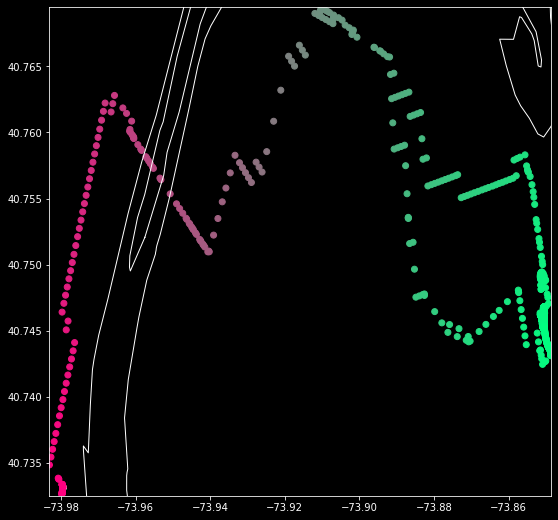

In [114]:
B = data[['lat1','lng1']].values
X = data[['lat2','lng2']].values
rgb = np.zeros((X.shape[0],3))
rgb[:,0] = 1-data['distance_norm'].values
rgb[:,1] = data['distance_norm'].values
rgb[:,2] = 0.5#1-data['distance_norm'].values
offset = 0.0001
skip = 1
plt.figure(figsize=(9,9))
for i in range(len(parts)-1):
    spos = parts[i]
    epos = parts[i+1]
    polygon = points[spos:epos,:]
    plt.plot(polygon[:,0],polygon[:,1],c='w',linewidth=1);
plt.scatter(B[0,0],B[0,1],c='w')
plt.scatter(X[::skip,0],X[::skip,1],c=rgb[::skip,:])
minval = np.round(np.min(X,axis=0),5)
maxval = np.round(np.max(X,axis=0),5)
plt.axis((minval[0]-offset,maxval[0]+offset,minval[1]-offset,maxval[1]+offset));

### Count Pairs

In [115]:
count = 0
for node1 in P:
    for node2 in P[node1]:
        count = count +1
print(count)
print(nNodes*nNodes)

237247
122857961121


### Save P

In [116]:
X = {}
X['P'] = P
pickle.dump(X,open('../data/paths/nyc_distances.p',"wb"))